In [1]:
%load_ext autoreload
%autoreload 2

### data loading and preparation

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

/home/ec2-user/miniforge3/envs/concord/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
proj_name = "cel_packerN2_hyperv3"
file_name = "cel_packerN2_hyperv3"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad')
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

In [5]:
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
adata = sc.read_h5ad(data_dir / DATA_FILE)

### Create jobs

In [10]:
import json, math, subprocess, scanpy as sc
from pathlib import Path

# ------------------------------------------------------------
# 1. global sweep settings
# ------------------------------------------------------------
TOTAL_STEPS   = 10000          # keep *updates* per run constant
BASE_LR       = 1e-2            # lr used at BASE_BATCH
BASE_BATCH    = 256              # reference batch for LR scaling


N_CELLS = adata.n_obs
print(f"✔ Dataset has {N_CELLS:,} cells")


✔ Dataset has 94,276 cells


In [ ]:
# HCL mode jobs
# ------------------------------------------------------------
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
# ------------------------------------------------------------

feature_list = ccd.ul.select_features(adata, n_top_features=10000, flavor='seurat_v3')
hcl_base_args = {
    "latent_dim": 300,
    "batch_size": BASE_BATCH,
    "input_feature": feature_list,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.0,
    "clr_beta": 1.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "dropout_prob": 0.0,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}

vegs = {
    1000 : ccd.ul.select_features(adata, n_top_features=1000,
                                  flavor="seurat_v3"),
    3000 : ccd.ul.select_features(adata, n_top_features=3000,
                                  flavor="seurat_v3"),
    4000 : ccd.ul.select_features(adata, n_top_features=4000,
                                  flavor="seurat_v3"),
    5000 : ccd.ul.select_features(adata, n_top_features=5000,
                                  flavor="seurat_v3"),
    6000 : ccd.ul.select_features(adata, n_top_features=6000,
                                  flavor="seurat_v3"),
    8000 : ccd.ul.select_features(adata, n_top_features=8000,
                                  flavor="seurat_v3"),
    10000: ccd.ul.select_features(adata, n_top_features=10000,
                                  flavor="seurat_v3"),
}

param_grid = {
    # "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    # "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    # "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    # "clr_beta" : [0.0, 0.5, 1.0, 2.0, 6.0],  # sweep 5 values
    # "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 5 values
    # "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    # "n_epochs": [1, 2, 3, 4, 5, 10, 15, 20, 30]
    "dropout_prob": [0.0, 0.1, 0.2],
    "input_feature": list(vegs.values())
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
hcl_jobs = ccd.bm.expand_one_at_a_time(
    hcl_base_args,
    param_grid,
    base_tag="concord_hcl",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in hcl_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE.name,
        "--methods",        "concord_hcl",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "concord",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(hcl_jobs)} jobs for concord_hcl mode in {output_dir}")

concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
✔ 256 batch size: 28 epochs, 369 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_hcl_concord_hcl_dropout_prob-0_0.py
✅ Generated: benchmark_cel_packe

In [67]:
# KNN mode jobs
# ------------------------------------------------------------
# 2. base & grid
# ------------------------------------------------------------
knn_base_args = {
    "latent_dim": 300,
    "batch_size": BASE_BATCH,
    "input_feature": feature_list,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.3,
    "clr_beta": 0.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "dropout_prob": 0.0,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}


param_grid = {
    # "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    # "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    # "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    # "p_intra_knn" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    # "sampler_knn": [100, 300, 1000, 3000, 10000],  # sweep 5 values
    # "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
    # "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    # "n_epochs": [1,2,3,4,5, 10, 15, 20, 30]
    "dropout_prob": [0.0, 0.1, 0.2],
    "input_feature": list(vegs.values())
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
knn_jobs = ccd.bm.expand_one_at_a_time(
    knn_base_args,
    param_grid,
    base_tag="concord_knn",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in knn_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # b) scale learning-rate linearly with batch size
    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE.name,
        "--methods",        "concord_knn",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "cellpath",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(knn_jobs)} jobs for concord_knn mode in {output_dir}")

✔ 256 batch size: 28 epochs, 369 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_concord_knn_dropout_prob-0_0.py
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_concord_knn_dropout_prob-0_0.sh

✔ 256 batch size: 28 epochs, 369 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_concord_knn_dropout_prob-0_1.py
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_concord_knn_dropout_prob-0_1.sh

✔ 256 batch size: 28 epochs, 369 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_concord_knn_dropout_prob-0_2.py
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_concord_knn_dropout_prob-0_2.sh

✔ 256 batch size: 28 epochs, 369 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv3/benchmark_cel_packerN2_hyperv3_concord_knn_

In [64]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_cel_packerN2_hyperv3/submit_all_cel_packerN2_hyperv3.sh” to queue every job.


In [69]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = f"""#!/usr/bin/env bash
set -euo pipefail
cd "$(dirname "$0")"            # work inside this folder (../jobs)
shopt -s nullglob

for job in benchmark_{proj_name}_*.py; do
  base=${{job%.py}}
  log="${{base}}.log"

  # ───────────────────────────────────────────────────────────────
  # skip if a previous run finished successfully
  # ───────────────────────────────────────────────────────────────
  if [[ -f "$log" ]] && grep -q "finished OK" "$log"; then
      echo ">>> SKIP $job  — already completed"
      continue
  fi

  echo ">>> $job   $(date)" | tee -a "$log"
  if python "$job" >>"$log" 2>&1; then
      echo ">>> finished OK" | tee -a "$log"
  else
      echo ">>> FAILED"      | tee -a "$log"
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_cel_packerN2_hyperv3/submit_sequential_cel_packerN2_hyperv3.sh” to queue jobs sequentially.


### Collect results

In [75]:
# Delete existing latents in adata.obsm
for key in list(adata.obsm.keys()):
    del adata.obsm[key]

In [76]:
# hcl_keys = [kw['output_key'] for kw in hcl_jobs]
# knn_keys = []
# methods = hcl_keys + knn_keys
# print(f"total methods: {len(methods)}")

# Auto detect runned methods in the save_dir
import re
from typing import List, Optional
_RUN_DIR_RE = re.compile(r'^(concord_(?:hcl|knn)_.+?)_\d{4}-\d{4}$')

def discover_methods(save_root: Path) -> List[str]:
    """
    Scan `save_root` for run folders and return a sorted list of
    unique method prefixes (without the timestamp).
    """
    methods = {
        m.group(1)
        for p in save_root.iterdir()
        if p.is_dir() and (m := _RUN_DIR_RE.match(p.name))
    }
    return sorted(methods)

In [77]:
methods = discover_methods(save_dir)
methods

['concord_hcl_dropout_prob-0.0',
 'concord_hcl_dropout_prob-0.1',
 'concord_hcl_dropout_prob-0.2',
 'concord_hcl_input_feature-4000',
 'concord_hcl_input_feature-6000',
 'concord_hcl_input_feature-8000',
 'concord_hcl_input_feature_1000',
 'concord_hcl_input_feature_10000',
 'concord_hcl_input_feature_3000',
 'concord_hcl_input_feature_5000',
 'concord_knn_dropout_prob-0.0',
 'concord_knn_dropout_prob-0.1',
 'concord_knn_dropout_prob-0.2',
 'concord_knn_input_feature-4000',
 'concord_knn_input_feature-6000',
 'concord_knn_input_feature-8000',
 'concord_knn_input_feature_1000',
 'concord_knn_input_feature_10000',
 'concord_knn_input_feature_3000',
 'concord_knn_input_feature_5000']

In [78]:
#methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive", "seurat_cca", "seurat_rpca"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
#adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad') # Load the log normalized but unfiltered adata
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)
methods = [m for m in methods if m in adata.obsm.keys()]

✅ obsm['concord_hcl_dropout_prob-0.0'] loaded
✅ obsm['concord_hcl_dropout_prob-0.1'] loaded
✅ obsm['concord_hcl_dropout_prob-0.2'] loaded
✅ obsm['concord_hcl_input_feature-4000'] loaded
✅ obsm['concord_hcl_input_feature-6000'] loaded
✅ obsm['concord_hcl_input_feature-8000'] loaded
✅ obsm['concord_hcl_input_feature_1000'] loaded
✅ obsm['concord_hcl_input_feature_10000'] loaded
✅ obsm['concord_hcl_input_feature_3000'] loaded
✅ obsm['concord_hcl_input_feature_5000'] loaded
✅ obsm['concord_knn_dropout_prob-0.0'] loaded
✅ obsm['concord_knn_dropout_prob-0.1'] loaded
✅ obsm['concord_knn_dropout_prob-0.2'] loaded
✅ obsm['concord_knn_input_feature-4000'] loaded
✅ obsm['concord_knn_input_feature-6000'] loaded
✅ obsm['concord_knn_input_feature-8000'] loaded
✅ obsm['concord_knn_input_feature_1000'] loaded
✅ obsm['concord_knn_input_feature_10000'] loaded
✅ obsm['concord_knn_input_feature_3000'] loaded
✅ obsm['concord_knn_input_feature_5000'] loaded


In [79]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype(str)  # Ensure all values are strings
adata.obs['cell_type'][adata.obs['cell_type'].isin(['', 'nan', 'NaN', 'NA', 'na', 'unannotated'])] = 'NaN'

### Benchmarking

✅ Benchmark summary saved to: ../save/cel_packerN2_hyperv3/benchmark_summary_Jul09-0055.tsv


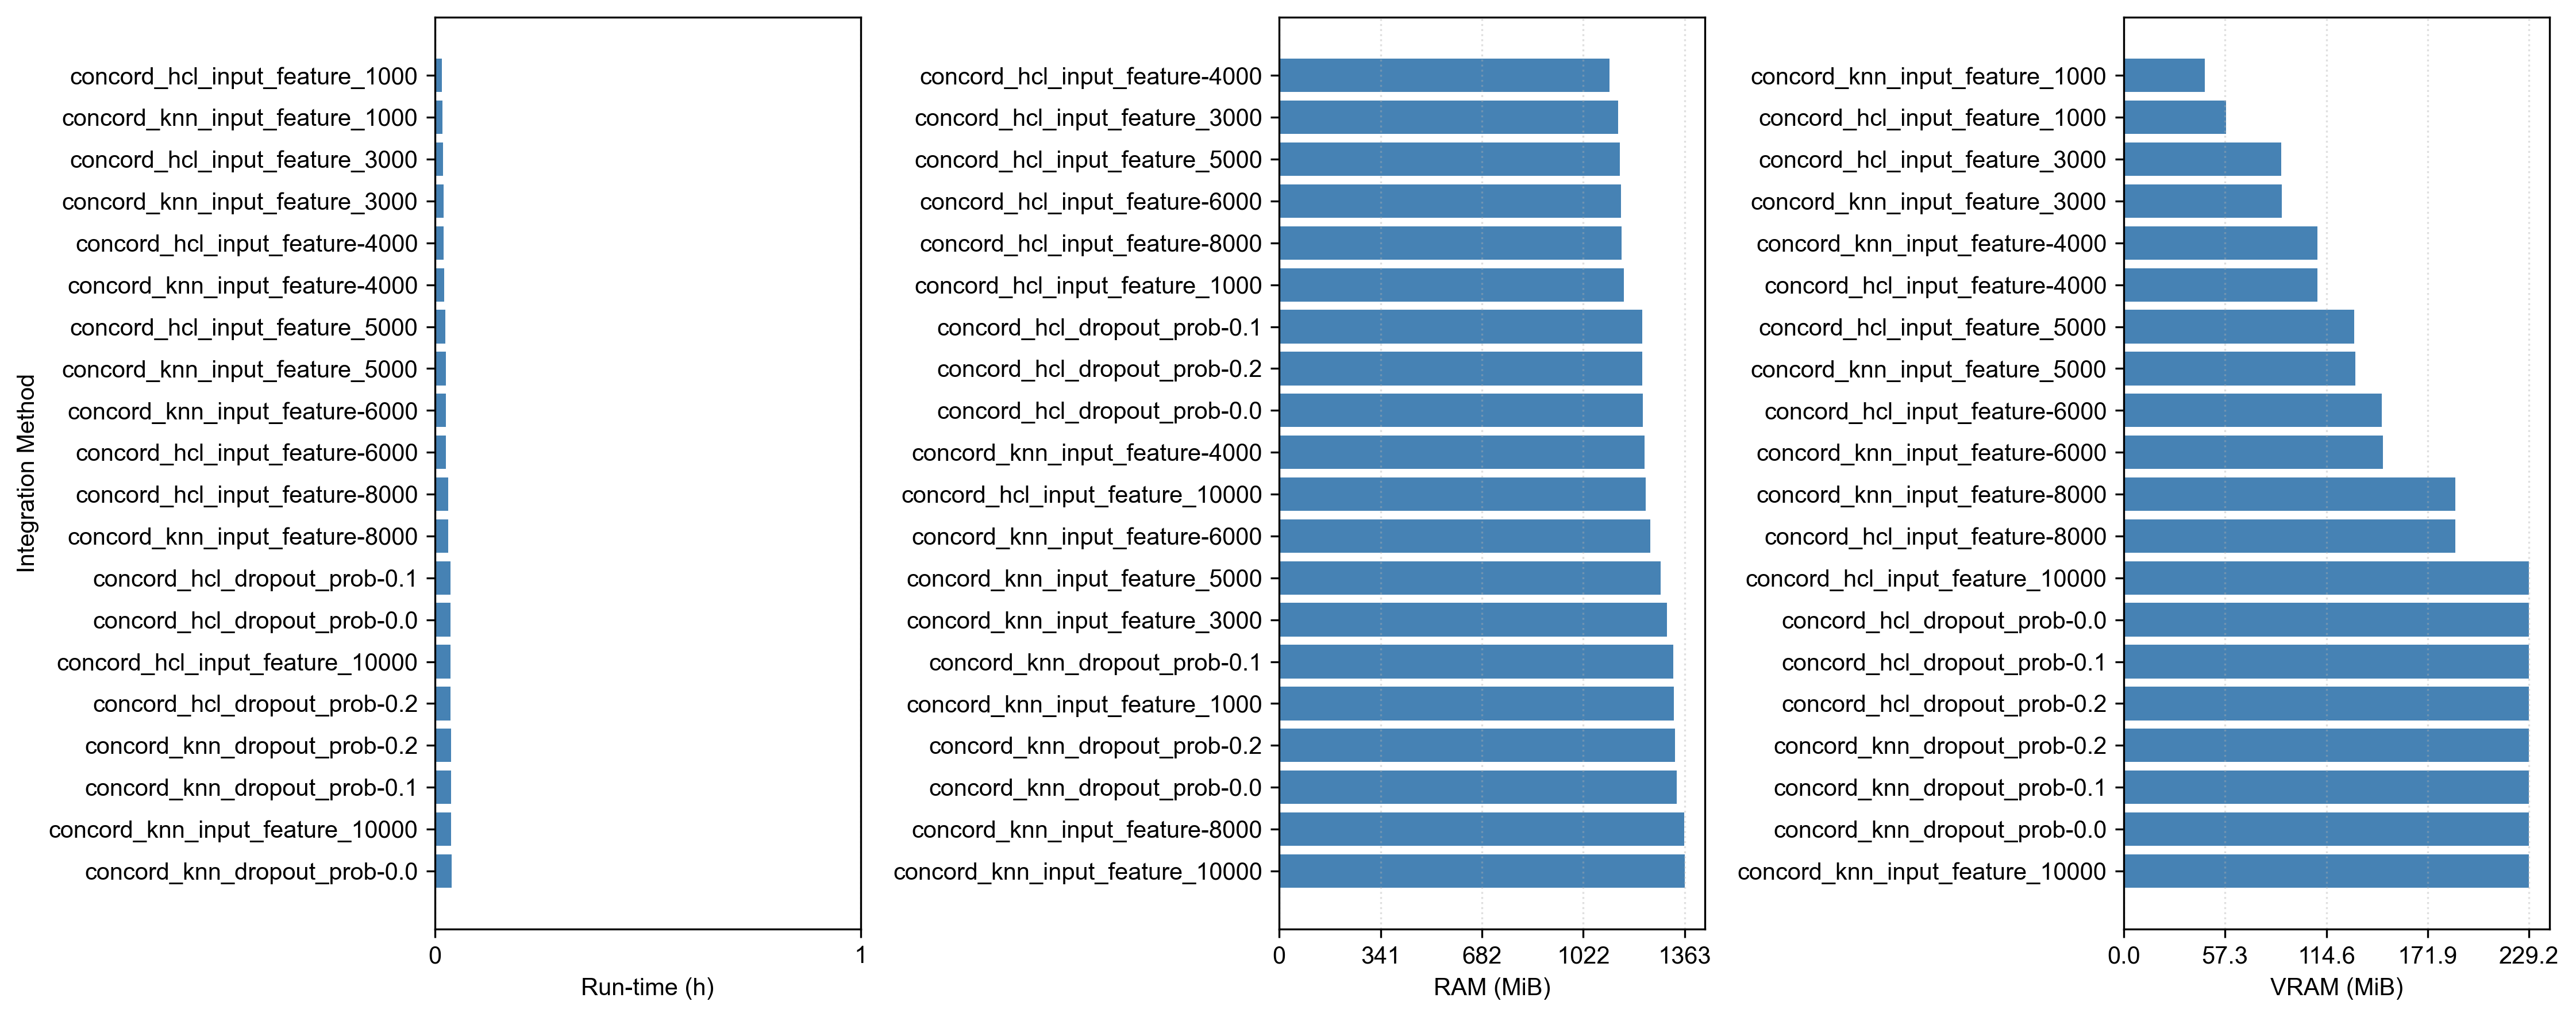

In [80]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(15,6), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


#### Benchmark cell type

In [81]:
adata.obsm

AxisArrays with keys: concord_hcl_dropout_prob-0.0, concord_hcl_dropout_prob-0.1, concord_hcl_dropout_prob-0.2, concord_hcl_input_feature-4000, concord_hcl_input_feature-6000, concord_hcl_input_feature-8000, concord_hcl_input_feature_1000, concord_hcl_input_feature_10000, concord_hcl_input_feature_3000, concord_hcl_input_feature_5000, concord_knn_dropout_prob-0.0, concord_knn_dropout_prob-0.1, concord_knn_dropout_prob-0.2, concord_knn_input_feature-4000, concord_knn_input_feature-6000, concord_knn_input_feature-8000, concord_knn_input_feature_1000, concord_knn_input_feature_10000, concord_knn_input_feature_3000, concord_knn_input_feature_5000

In [82]:
import numpy as np
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']
bad_cells = adata.obs['cell_type'].isin(bad_annotation) 
adata_ct = adata[~bad_cells].copy()
print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_ct.shape}")

✅ Filtered adata to remove bad annotations, new shape: (43686, 13405)


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_dropout_prob-0.0', 'concord_hcl_dropout_prob-0.1', 'concord_hcl_dropout_prob-0.2', 'concord_hcl_input_feature-4000', 'concord_hcl_input_feature-6000', 'concord_hcl_input_feature-8000', 'concord_hcl_input_feature_1000', 'concord_hcl_input_feature_10000', 'concord_hcl_input_feature_3000', 'concord_hcl_input_feature_5000', 'concord_knn_dropout_prob-0.0', 'concord_knn_dropout_prob-0.1', 'concord_knn_dropout_prob-0.2', 'concord_knn_input_feature-4000', 'concord_knn_input_feature-6000', 'concord_knn_input_feature-8000', 'concord_knn_input_feature_1000', 'concord_knn_input_feature_10000', 'concord_knn_input_feature_3000', 'concord_knn_input_feature_5000']


Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['concord_hcl_dropout_prob-0.0', 'concord_hcl_dropout_prob-0.1', 'concord_hcl_dropout_prob-0.2', 'concord_hcl_input_feature-4000', 'concord_hcl_input_feature-6000', 'concord_hcl_input_feature-8000', 'concord_hcl_input_feature_1000', 'concord_hcl_input_feature_10000', 'concord_hcl_input_feature_3000', 'concord_hcl_input_feature_5000', 'concord_knn_dropout_prob-0.0', 'concord_knn_dropout_prob-0.1', 'concord_knn_dropout_prob-0.2', 'concord_knn_input_feature-4000', 'concord_knn_input_feature-6000', 'concord_knn_input_feature-8000', 'concord_knn_input_feature_1000', 'concord_knn_input_feature_10000', 'concord_knn_input_feature_3000', 'concord_knn_input_feature_5000']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['concord_hcl_dropout_prob-0.0', 'concord_hcl_dropout_prob-0.1', 'concord_hcl_dropout_prob-0.2', 'concord_hcl

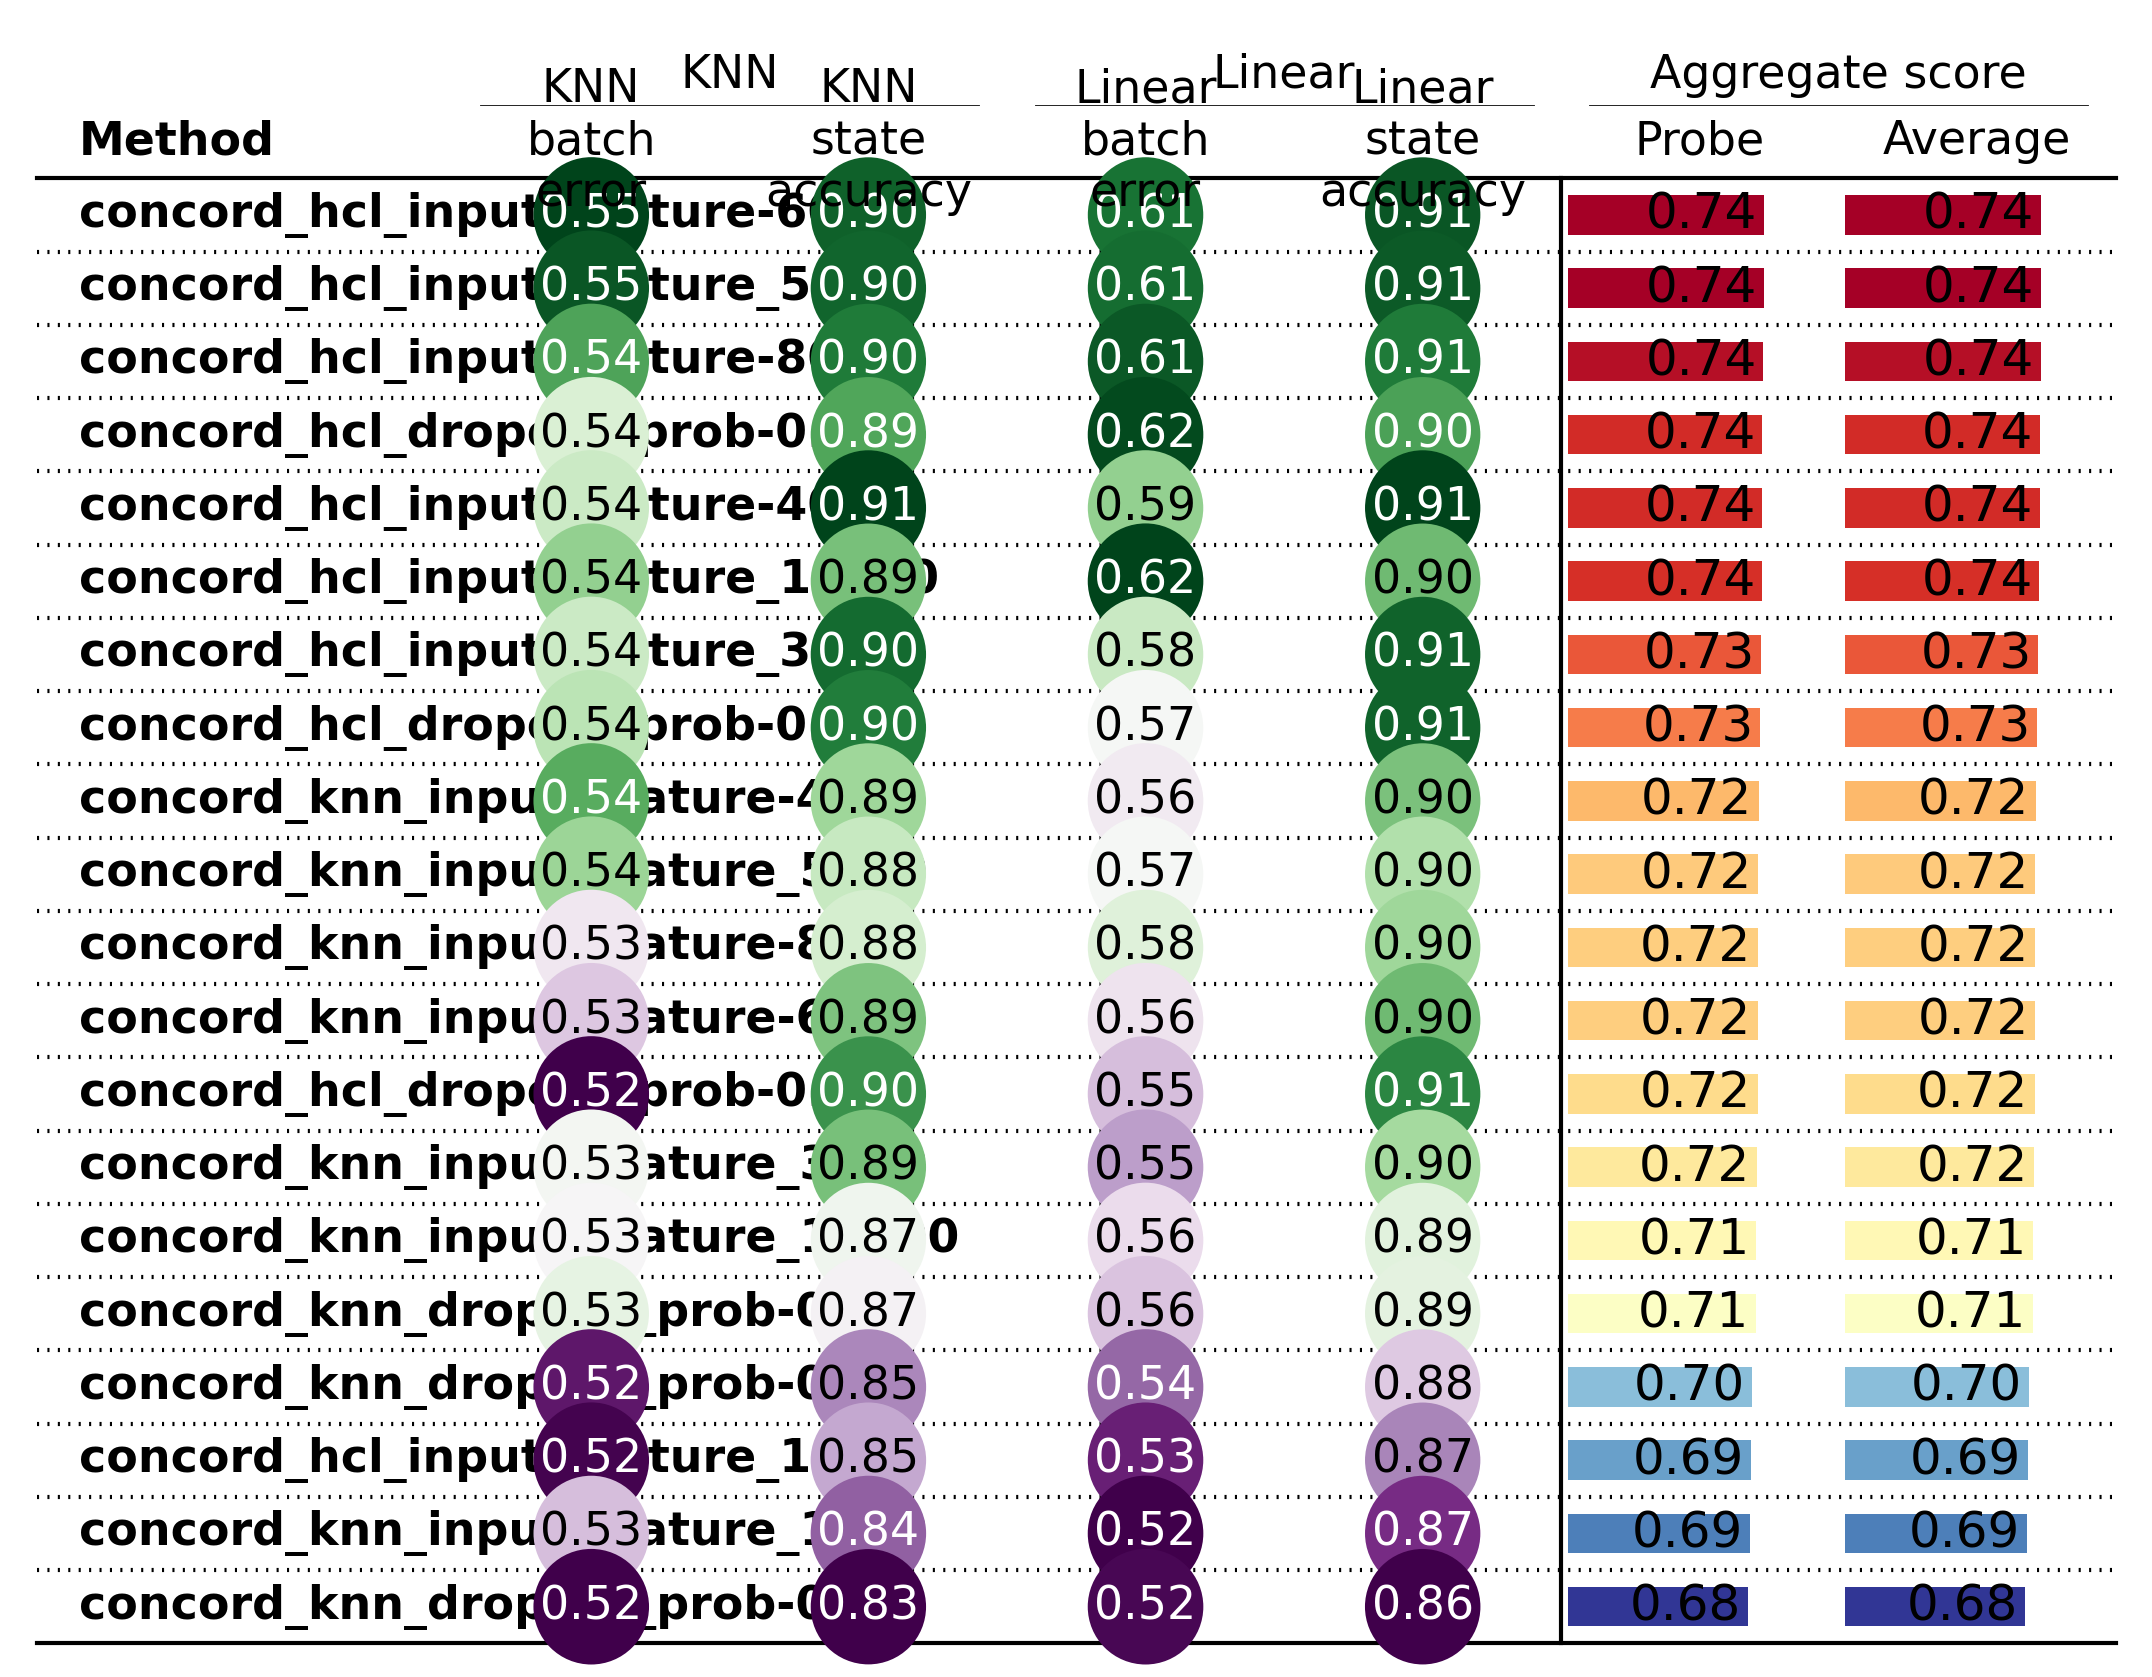

✅ Benchmark results saved to: ../save/cel_packerN2_hyperv3/benchmark_cell_type_Jul09-0055.pkl


In [83]:
state_key = 'cell_type'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata_ct,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")

In [84]:
combined_celltype.to_csv(save_dir / f"combined_celltype_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined cell type results saved to: {save_dir / f'combined_celltype_{file_suffix}.tsv'}")

✅ Combined cell type results saved to: ../save/cel_packerN2_hyperv3/combined_celltype_Jul09-0055.tsv


In [85]:
combined_celltype

KNN                       Linear  \
                                batch\nerror state\naccuracy batch\nerror   
Method                                                                      
concord_hcl_input_feature-6000      0.547837        0.903754     0.607646   
concord_hcl_input_feature_5000      0.546693        0.903296     0.608905   
concord_hcl_input_feature-8000      0.542344        0.899748     0.612796   
concord_hcl_dropout_prob-0.0        0.535477        0.893797     0.615429   
concord_hcl_input_feature-4000      0.536393        0.908331     0.590134   
concord_hcl_input_feature_10000     0.539368        0.889334     0.616688   
concord_hcl_input_feature_3000      0.536393        0.902495     0.580977   
concord_hcl_dropout_prob-0.1        0.537423        0.899634     0.568960   
concord_knn_input_feature-4000      0.541772        0.885443     0.564610   
concord_knn_input_feature_5000      0.539025        0.879721     0.568731   
concord_knn_input_feature-8000      0.531243        0.877432     0.575827   
concord_knn_input_feature-6000      0.528725        0.888762     0.562893   
concord_hcl_dropout_prob-0.2        0.517395        0.896544     0.554195   
concord_knn_input_feature_3000      0.532959        0.889334     0.547556   
concord_knn_input_feature_10000     0.532387        0.871023     0.560833   
concord_knn_dropout_prob-0.0        0.534333        0.867704     0.555339   
concord_knn_dropout_prob-0.1        0.518997        0.849050     0.538285   
concord_hcl_input_feature_1000      0.517624        0.853971     0.527183   
concord_knn_input_feature_1000      0.528038        0.843786     0.519744   
concord_knn_dropout_prob-0.2        0.517281        0.829824     0.521346   

                                                Aggregate score            
                                state\naccuracy           Probe   Average  
Method                                                                     
concord_hcl_input_feature-6000         0.911755        0.742748  0.742748  
concord_hcl_input_feature_5000         0.911297        0.742547  0.742547  
concord_hcl_input_feature-8000         0.907863        0.740688  0.740688  
concord_hcl_dropout_prob-0.0           0.904201        0.737226  0.737226  
concord_hcl_input_feature-4000         0.913815        0.737168  0.737168  
concord_hcl_input_feature_10000        0.901339        0.736682  0.736682  
concord_hcl_input_feature_3000         0.910610        0.732619  0.732619  
concord_hcl_dropout_prob-0.1           0.910496        0.729128  0.729128  
concord_knn_input_feature-4000         0.900538        0.723091  0.723091  
concord_knn_input_feature_5000         0.896189        0.720916  0.720916  
concord_knn_input_feature-8000         0.897905        0.720602  0.720602  
concord_knn_input_feature-6000         0.901454        0.720458  0.720458  
concord_hcl_dropout_prob-0.2           0.906947        0.718770  0.718770  
concord_knn_input_feature_3000         0.897448        0.716824  0.716824  
concord_knn_input_feature_10000        0.890580        0.713706  0.713706  
concord_knn_dropout_prob-0.0           0.890008        0.711846  0.711846  
concord_knn_dropout_prob-0.1           0.879821        0.696539  0.696539  
concord_hcl_input_feature_1000         0.872496        0.692819  0.692819  
concord_knn_input_feature_1000         0.865057        0.689156  0.689156  
concord_knn_dropout_prob-0.2           0.859334        0.681946  0.681946

#### Benchmark lineage

In [86]:
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']
bad_cells = adata.obs['lineage_complete'].isin(bad_annotation) 
adata_lineage = adata[~bad_cells].copy()
print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_lineage.shape}")

✅ Filtered adata to remove bad annotations, new shape: (35636, 13405)


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_dropout_prob-0.0', 'concord_hcl_dropout_prob-0.1', 'concord_hcl_dropout_prob-0.2', 'concord_hcl_input_feature-4000', 'concord_hcl_input_feature-6000', 'concord_hcl_input_feature-8000', 'concord_hcl_input_feature_1000', 'concord_hcl_input_feature_10000', 'concord_hcl_input_feature_3000', 'concord_hcl_input_feature_5000', 'concord_knn_dropout_prob-0.0', 'concord_knn_dropout_prob-0.1', 'concord_knn_dropout_prob-0.2', 'concord_knn_input_feature-4000', 'concord_knn_input_feature-6000', 'concord_knn_input_feature-8000', 'concord_knn_input_feature_1000', 'concord_knn_input_feature_10000', 'concord_knn_input_feature_3000', 'concord_knn_input_feature_5000']


Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['concord_hcl_dropout_prob-0.0', 'concord_hcl_dropout_prob-0.1', 'concord_hcl_dropout_prob-0.2', 'concord_hcl_input_feature-4000', 'concord_hcl_input_feature-6000', 'concord_hcl_input_feature-8000', 'concord_hcl_input_feature_1000', 'concord_hcl_input_feature_10000', 'concord_hcl_input_feature_3000', 'concord_hcl_input_feature_5000', 'concord_knn_dropout_prob-0.0', 'concord_knn_dropout_prob-0.1', 'concord_knn_dropout_prob-0.2', 'concord_knn_input_feature-4000', 'concord_knn_input_feature-6000', 'concord_knn_input_feature-8000', 'concord_knn_input_feature_1000', 'concord_knn_input_feature_10000', 'concord_knn_input_feature_3000', 'concord_knn_input_feature_5000']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['concord_hcl_dropout_prob-0.0', 'concord_hcl_dropout_prob-0.1', 'concord_hcl_dropout_prob-0.2', 'concord_hcl

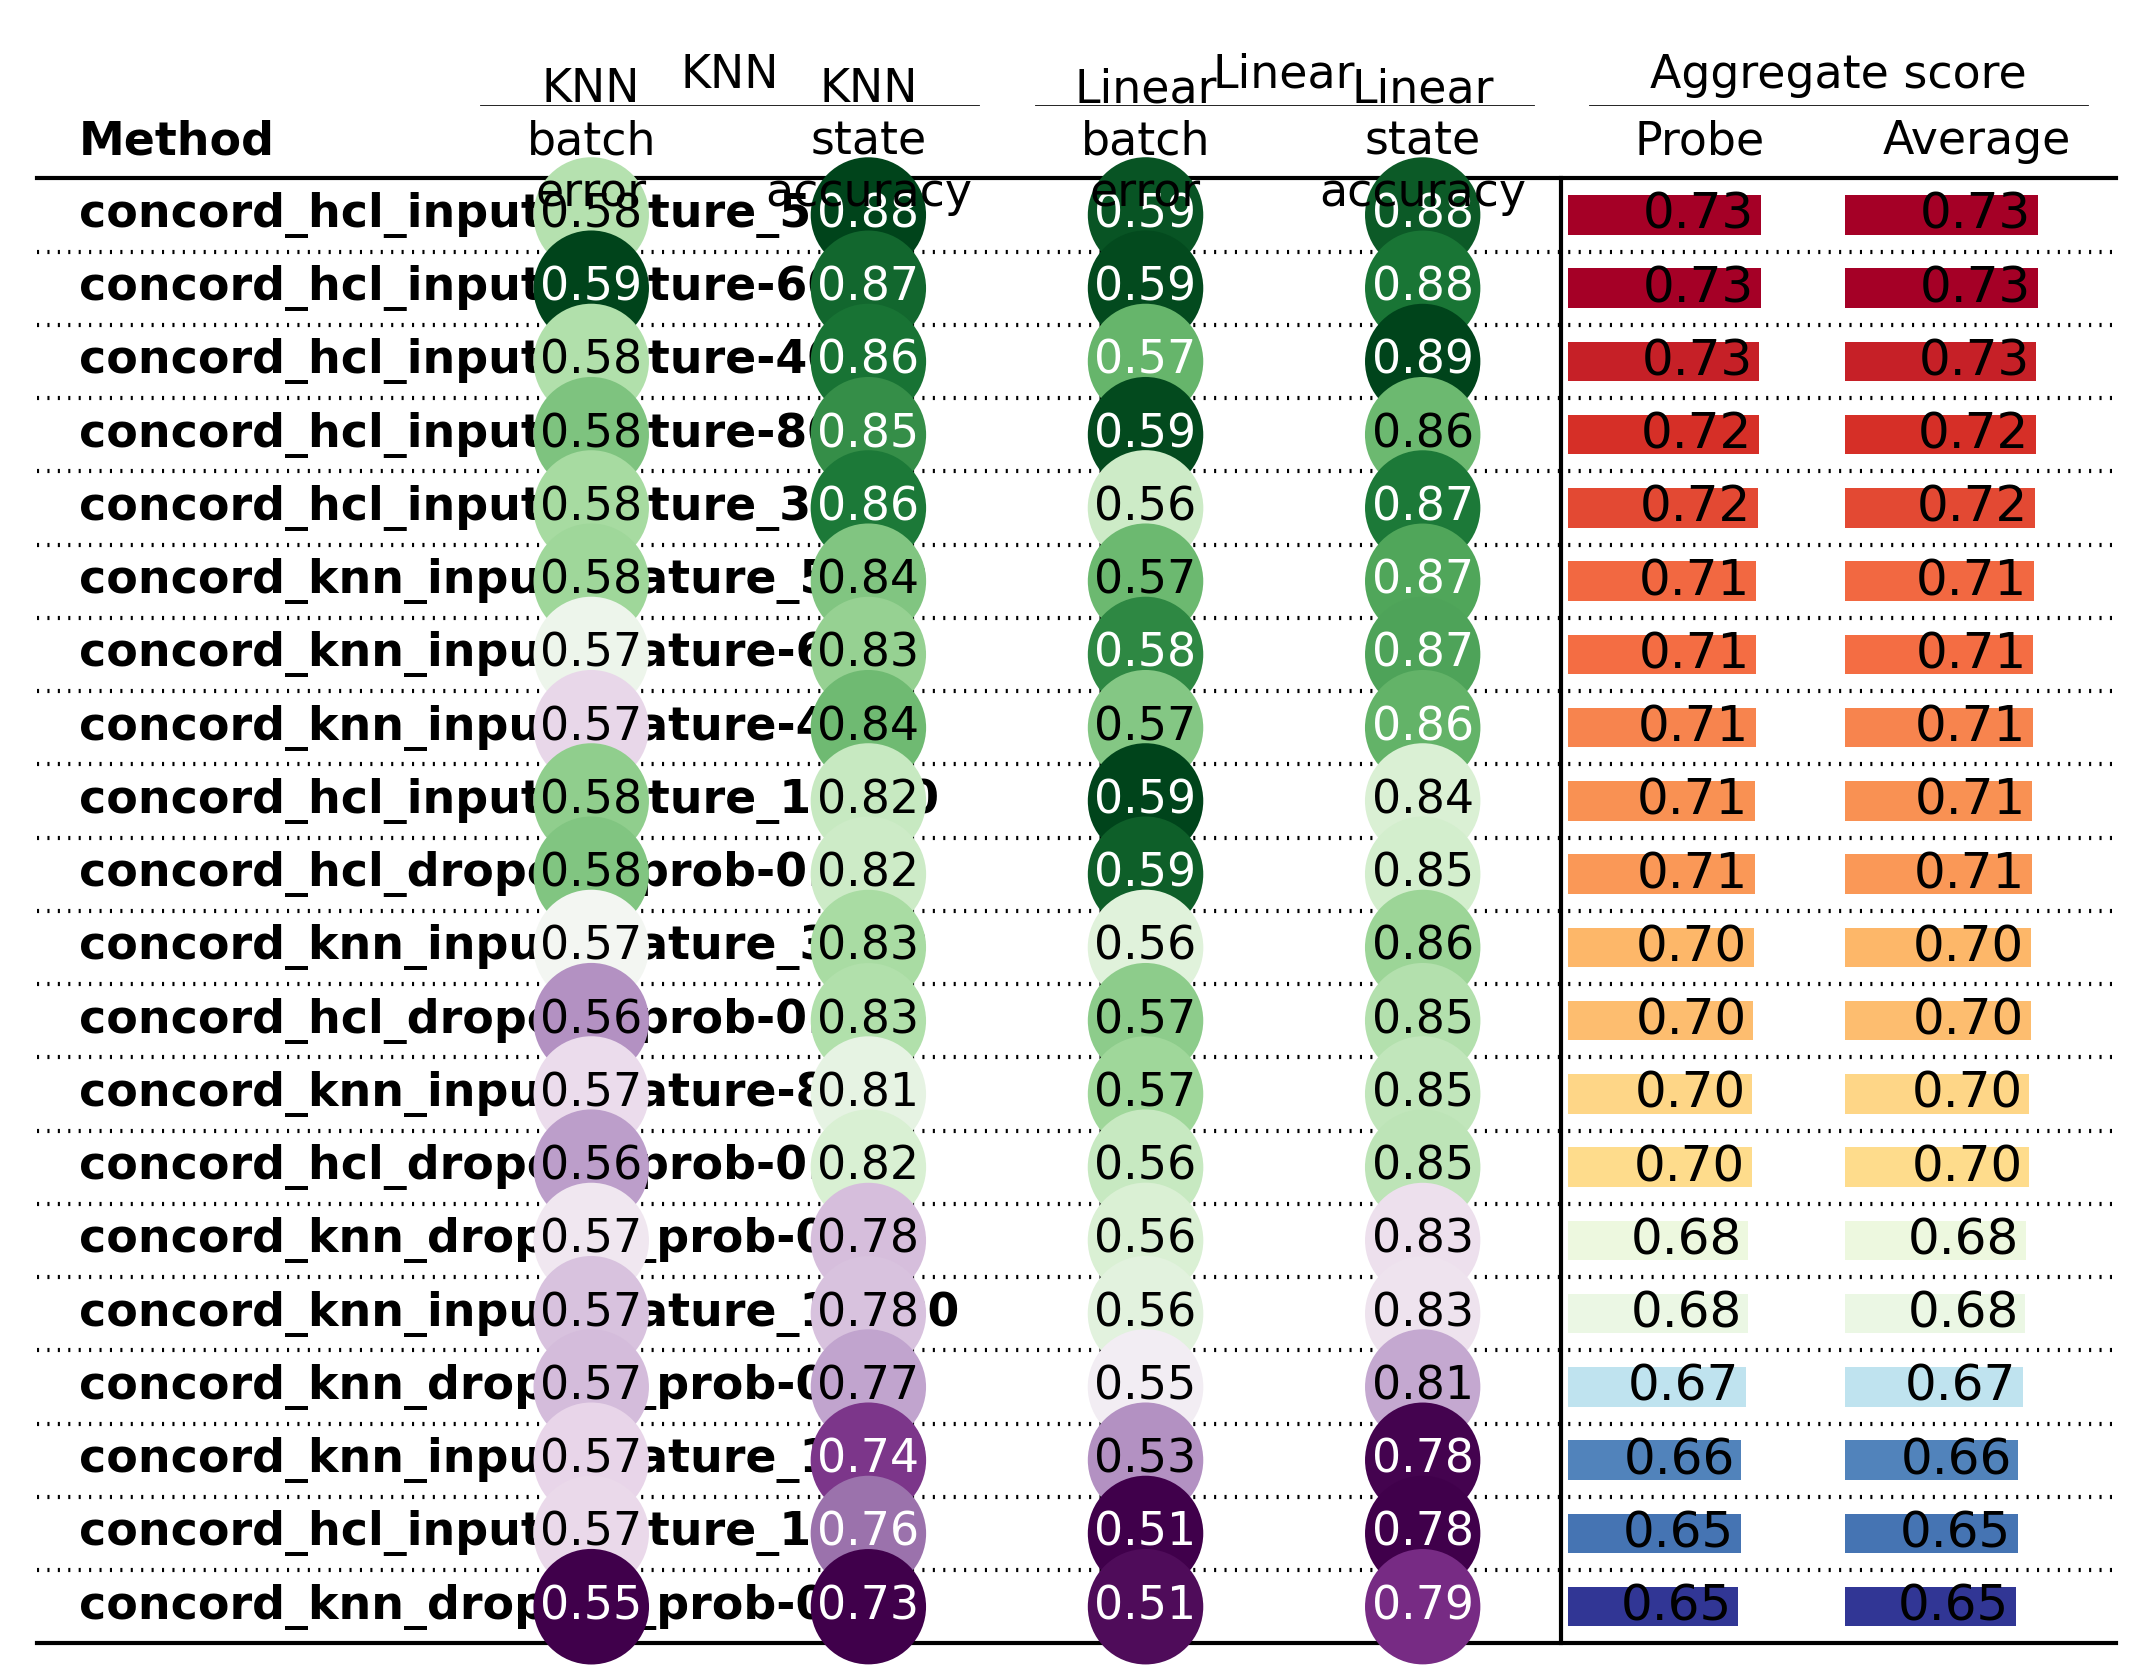

✅ Benchmark results saved to: ../save/cel_packerN2_hyperv3/benchmark_lineage_complete_Jul09-0055.pkl


In [87]:
state_key = 'lineage_complete'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata_lineage,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_lineage",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_lineage = out["combined"]
combined_lineage

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")


In [88]:
combined_lineage.to_csv(save_dir / f"combined_lineage_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined lineage results saved to: {save_dir / f'combined_lineage_{file_suffix}.tsv'}")

✅ Combined lineage results saved to: ../save/cel_packerN2_hyperv3/combined_lineage_Jul09-0055.tsv


In [89]:
combined_lineage

KNN                       Linear  \
                                batch\nerror state\naccuracy batch\nerror   
Method                                                                      
concord_hcl_input_feature_5000      0.578563        0.875421     0.588607   
concord_hcl_input_feature-6000      0.591470        0.865039     0.590431   
concord_hcl_input_feature-4000      0.578844        0.861953     0.574155   
concord_hcl_input_feature-8000      0.581790        0.854377     0.590431   
concord_hcl_input_feature_3000      0.579545        0.859848     0.561246   
concord_knn_input_feature_5000      0.579966        0.837963     0.573453   
concord_knn_input_feature-6000      0.573092        0.833754     0.581030   
concord_knn_input_feature-4000      0.568182        0.841190     0.570787   
concord_hcl_input_feature_10000     0.580808        0.821128     0.591413   
concord_hcl_dropout_prob-0.0        0.581650        0.819024     0.587204   
concord_knn_input_feature_3000      0.572391        0.829545     0.557458   
concord_hcl_dropout_prob-0.1        0.562570        0.827160     0.570086   
concord_knn_input_feature-8000      0.568883        0.808923     0.568121   
concord_hcl_dropout_prob-0.2        0.563412        0.815376     0.562228   
concord_knn_dropout_prob-0.0        0.570006        0.778900     0.559001   
concord_knn_input_feature_10000     0.566358        0.780163     0.556756   
concord_knn_dropout_prob-0.1        0.565937        0.770483     0.549039   
concord_knn_input_feature_1000      0.568042        0.743967     0.532342   
concord_hcl_input_feature_1000      0.568603        0.756594     0.511155   
concord_knn_dropout_prob-0.2        0.552189        0.726010     0.513540   

                                                Aggregate score            
                                state\naccuracy           Probe   Average  
Method                                                                     
concord_hcl_input_feature_5000         0.880455        0.730761  0.730761  
concord_hcl_input_feature-6000         0.875544        0.730621  0.730621  
concord_hcl_input_feature-4000         0.885225        0.725044  0.725044  
concord_hcl_input_feature-8000         0.862354        0.722238  0.722238  
concord_hcl_input_feature_3000         0.874562        0.718800  0.718800  
concord_knn_input_feature_5000         0.866283        0.714416  0.714416  
concord_knn_input_feature-6000         0.866704        0.713645  0.713645  
concord_knn_input_feature-4000         0.863477        0.710909  0.710909  
concord_hcl_input_feature_10000        0.843833        0.709296  0.709296  
concord_hcl_dropout_prob-0.0           0.845377        0.708313  0.708313  
concord_knn_input_feature_3000         0.855619        0.703753  0.703753  
concord_hcl_dropout_prob-0.1           0.851691        0.702877  0.702877  
concord_knn_input_feature-8000         0.849025        0.698738  0.698738  
concord_hcl_dropout_prob-0.2           0.849726        0.697686  0.697686  
concord_knn_dropout_prob-0.0           0.827417        0.683831  0.683831  
concord_knn_input_feature_10000        0.828399        0.682919  0.682919  
concord_knn_dropout_prob-0.1           0.814087        0.674886  0.674886  
concord_knn_input_feature_1000         0.783920        0.657068  0.657068  
concord_hcl_input_feature_1000         0.782798        0.654787  0.654787  
concord_knn_dropout_prob-0.2           0.793321        0.646265  0.646265

### Visualize the results

In [90]:
import re
from pathlib import Path
import itertools

import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 0  CONFIG ─ paths, metric, cosmetics
# ───────────────────────────────────────────────────────────────
SAVE_ROOT   = save_dir
FILE_SUFFIX = file_suffix

CELL_TSV   = SAVE_ROOT / f"combined_celltype_{FILE_SUFFIX}.tsv"
LINE_TSV   = SAVE_ROOT / f"combined_lineage_{FILE_SUFFIX}.tsv"

BASE_CELL  = Path("../save/cel_packerN2_hyperparam/") / f"other_celltype_Jul03-1254.tsv"
BASE_LINE  = Path("../save/cel_packerN2_hyperparam/") / f"other_lineage_Jul03-1254.tsv"

METRIC_COL = "Aggregate score.1"          # ← use any column you like

COLORS     = {"Cell type": "#1f77b4",     # consistent colour palette
              "Lineage":   "#ff7f0e"}

# dash patterns for up to 8 baselines – extend / customise as needed
DASHES = ["solid", "dashed", "dotted", "dashdot",
          (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (1, 1)), (0, (5, 1, 1, 1))]
# ───────────────────────────────────────────────────────────────
# 1  Helpers
# ───────────────────────────────────────────────────────────────
score_cols = ["KNN", "KNN.1", "Linear", "Linear.1",
              "Aggregate score", "Aggregate score.1"]

_method_re = re.compile(
    r"concord_(hcl|knn)_(.+?)[-_]([0-9.]+)$"   # note  [-_]
)

def parse_method(name: str):
    m = _method_re.match(name)
    if m is None:
        return None, None, None
    mode, param, val = m.groups()
    try:
        val = float(val) if "." in val else int(val)
    except ValueError:
        pass
    return mode, param, val

def load_hyperparam_table(path: Path, target_label: str) -> pd.DataFrame:
    """Read hyper-parameter sweep table and return tidy frame."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df[["mode", "param", "value"]] = df["Unnamed: 0"].apply(
        lambda s: pd.Series(parse_method(s))
    )
    print(df)
    df["acc"]   = df[METRIC_COL]
    df["target"] = target_label
    return df.dropna(subset=["mode", "param"])


def load_baseline_table(path: Path, target_label: str) -> pd.DataFrame:
    """Baseline tables have one row per method (no hyper-params)."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df["method"]  = df["Unnamed: 0"].str.strip()
    df["acc"]     = df[METRIC_COL]
    df["target"]  = target_label
    return (df[["method", "acc", "target"]]
              .dropna(subset=["method"]))

# ───────────────────────────────────────────────────────────────
# 2  Load and fuse data
# ───────────────────────────────────────────────────────────────
hp_cell  = load_hyperparam_table(CELL_TSV,  "Cell type")
hp_line  = load_hyperparam_table(LINE_TSV,  "Lineage")

hyper_df = pd.concat([hp_cell, hp_line], ignore_index=True)

baseline_cell = load_baseline_table(BASE_CELL, "Cell type")
baseline_line = load_baseline_table(BASE_LINE, "Lineage")
baseline_df   = pd.concat([baseline_cell, baseline_line], ignore_index=True)

# mean across repeats (if any)
hp_summary = (hyper_df
              .groupby(["mode", "param", "value", "target"], as_index=False)["acc"]
              .mean())

base_summary = (baseline_df
                .groupby(["method", "target"], as_index=False)["acc"]
                .mean())

# Drop previous concord_hcl and concord_knn methods
base_summary = base_summary[~base_summary["method"].isin(["concord_hcl", "concord_knn", "seurat_cca"])]

# assign dash-patterns to each method
style_map = {m: d for m, d in zip(base_summary["method"].unique(),
                                  itertools.cycle(DASHES))}


                         Unnamed: 0       KNN     KNN.1    Linear  Linear.1  \
2    concord_hcl_input_feature-6000  0.547837  0.903754  0.607646  0.911755   
3    concord_hcl_input_feature_5000  0.546693  0.903296  0.608905  0.911297   
4    concord_hcl_input_feature-8000  0.542344  0.899748  0.612796  0.907863   
5      concord_hcl_dropout_prob-0.0  0.535477  0.893797  0.615429  0.904201   
6    concord_hcl_input_feature-4000  0.536393  0.908331  0.590134  0.913815   
7   concord_hcl_input_feature_10000  0.539368  0.889334  0.616688  0.901339   
8    concord_hcl_input_feature_3000  0.536393  0.902495  0.580977  0.910610   
9      concord_hcl_dropout_prob-0.1  0.537423  0.899634  0.568960  0.910496   
10   concord_knn_input_feature-4000  0.541772  0.885443  0.564610  0.900538   
11   concord_knn_input_feature_5000  0.539025  0.879721  0.568731  0.896189   
12   concord_knn_input_feature-8000  0.531243  0.877432  0.575827  0.897905   
13   concord_knn_input_feature-6000  0.528725  0.888

In [91]:
load_hyperparam_table(CELL_TSV,  "Cell type")

                         Unnamed: 0       KNN     KNN.1    Linear  Linear.1  \
2    concord_hcl_input_feature-6000  0.547837  0.903754  0.607646  0.911755   
3    concord_hcl_input_feature_5000  0.546693  0.903296  0.608905  0.911297   
4    concord_hcl_input_feature-8000  0.542344  0.899748  0.612796  0.907863   
5      concord_hcl_dropout_prob-0.0  0.535477  0.893797  0.615429  0.904201   
6    concord_hcl_input_feature-4000  0.536393  0.908331  0.590134  0.913815   
7   concord_hcl_input_feature_10000  0.539368  0.889334  0.616688  0.901339   
8    concord_hcl_input_feature_3000  0.536393  0.902495  0.580977  0.910610   
9      concord_hcl_dropout_prob-0.1  0.537423  0.899634  0.568960  0.910496   
10   concord_knn_input_feature-4000  0.541772  0.885443  0.564610  0.900538   
11   concord_knn_input_feature_5000  0.539025  0.879721  0.568731  0.896189   
12   concord_knn_input_feature-8000  0.531243  0.877432  0.575827  0.897905   
13   concord_knn_input_feature-6000  0.528725  0.888

,Unnamed: 0,KNN,KNN.1,Linear,Linear.1,Aggregate score,Aggregate score.1,mode,param,value,acc,target
2,concord_hcl_input_feature-6000,0.547837,0.903754,0.607646,0.911755,0.742748,0.742748,hcl,input_feature,6000.0,0.742748,Cell type
3,concord_hcl_input_feature_5000,0.546693,0.903296,0.608905,0.911297,0.742547,0.742547,hcl,input_feature,5000.0,0.742547,Cell type
4,concord_hcl_input_feature-8000,0.542344,0.899748,0.612796,0.907863,0.740688,0.740688,hcl,input_feature,8000.0,0.740688,Cell type
5,concord_hcl_dropout_prob-0.0,0.535477,0.893797,0.615429,0.904201,0.737226,0.737226,hcl,dropout_prob,0.0,0.737226,Cell type
6,concord_hcl_input_feature-4000,0.536393,0.908331,0.590134,0.913815,0.737168,0.737168,hcl,input_feature,4000.0,0.737168,Cell type
7,concord_hcl_input_feature_10000,0.539368,0.889334,0.616688,0.901339,0.736682,0.736682,hcl,input_feature,10000.0,0.736682,Cell type
8,concord_hcl_input_feature_3000,0.536393,0.902495,0.580977,0.910610,0.732619,0.732619,hcl,input_feature,3000.0,0.732619,Cell type
9,concord_hcl_dropout_prob-0.1,0.537423,0.899634,0.568960,0.910496,0.729128,0.729128,hcl,dropout_prob,0.1,0.729128,Cell type
10,concord_knn_input_feature-4000,0.541772,0.885443,0.564610,0.900538,0.723091,0.723091,knn,input_feature,4000.0,0.723091,Cell type
11,concord_knn_input_feature_5000,0.539025,0.879721,0.568731,0.896189,0.720916,0.720916,knn,input_feature,5000.0,0.720916,Cell type


In [92]:
# ───────────────────────────────────────────────────────────────
# Default values and recommended ranges
# ───────────────────────────────────────────────────────────────
HP_GUIDE = {
    #   param_name         default     (low ,  high)  ← inclusive
    "batch_size":          (256,        (128,   2048)),
    "latent_dim":          (100,        (50,  500)),
    "p_intra_domain":      (1.0,        (0.9,  1.0)),
    "clr_beta":            (1.0,        (0.5,  2.0)),
    "augmentation_mask_prob": (0.3,     (0.1,  0.5)),
    "clr_temperature":     (0.3,        (0.2,  0.5)),
    "n_epochs":            (10,         (5,   30)),
    "p_intra_knn":       (0.3,        (0.1,  0.5)),  # if you plot this one
    "sampler_knn":         (1000,       (300, 10000)),   # if you plot this one
    "dropout_prob":        (0.0,        (0.0,  0.0)),  # if you plot this one
    "input_feature":       (10000,      (2000, 10000)),
}


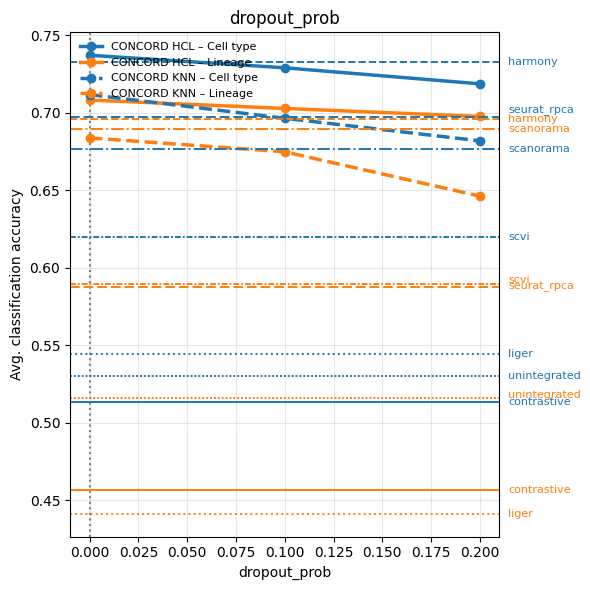

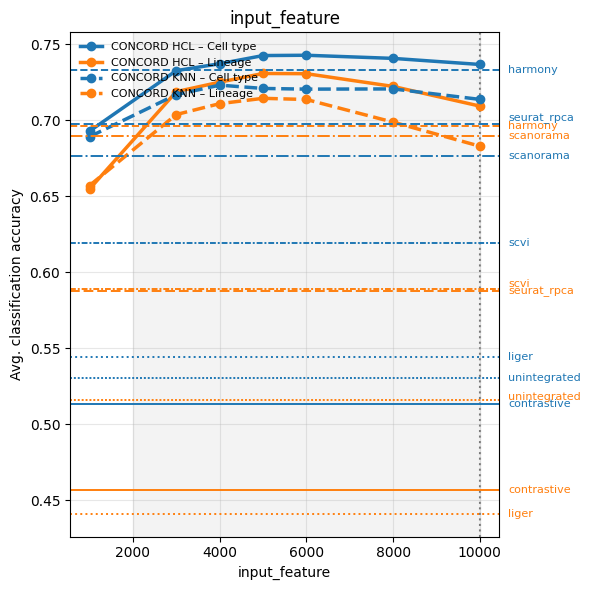

In [93]:
import numpy as np
import matplotlib.transforms as mtrans

# map CONCORD variant → line style
MODE_STYLE = {"hcl": "solid", "knn": "dashed"}
CONCORD_W  = 2.5          # linewidth for CONCORD curves
BASE_W     = 1.4          # linewidth for baselines

# ───────────────────────────────────────────────────────────────
# 3  Plot  —  HCL & k-NN together, labels outside, no overlap
# ───────────────────────────────────────────────────────────────
for param, sub in hp_summary.groupby("param"):          # ← only `param`
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(right=0.78)                     # room for labels

    default, (low, high) = HP_GUIDE.get(param, (None, (None, None)))

    if default is not None:
        # vertical line
        ax.axvline(default, color="#777777", linestyle=":", linewidth=1.5,
                   zorder=0.5, label="_nolegend_")          # no legend entry
    if low is not None and high is not None:
        # shaded range
        ax.axvspan(low, high, color="#dddddd", alpha=0.35,
                   zorder=0.4, label="_nolegend_")

    # 3-A  CONCORD curves
    for (mode, tgt), grp in sub.groupby(["mode", "target"]):
        grp = grp.sort_values("value")
        ax.plot(grp["value"], grp["acc"],
                marker="o",
                linestyle=MODE_STYLE[mode],
                linewidth=CONCORD_W,
                color=COLORS[tgt],
                label=f"CONCORD {mode.upper()} – {tgt}")

    # 3-B  Baseline horizontals
    label_info = []             # collect (y, tgt, method)
    for _, row in base_summary.iterrows():
        tgt, method, y = row["target"], row["method"], row["acc"]
        ax.axhline(y, color=COLORS[tgt],
                   linestyle=style_map[method],
                   linewidth=BASE_W)
        label_info.append([y, tgt, method])

    # ──  avoid label overlap  ────────────────────────────────
    label_info.sort()                          # sort by y
    min_sep = 0.015 * np.ptp(ax.get_ylim())    # 1.5 % of y-range
    for i in range(1, len(label_info)):
        if label_info[i][0] - label_info[i-1][0] < min_sep:
            label_info[i][0] = label_info[i-1][0] + min_sep

    # keep everything inside the y-limits
    ymax = ax.get_ylim()[1]
    overshoot = label_info[-1][0] - ymax
    if overshoot > 0:
        for lab in label_info:
            lab[0] -= overshoot

    # ──  place text outside the axes  ────────────────────────
    trans = mtrans.blended_transform_factory(ax.transAxes, ax.transData)
    for y, tgt, method in label_info:
        ax.text(1.02, y, method,
                color=COLORS[tgt], fontsize=8,
                va="center", ha="left", transform=trans)

    # ──  cosmetics  ──────────────────────────────────────────
    ax.set_title(f"{param}")
    ax.set_xlabel(param)
    ax.set_ylabel("Avg. classification accuracy")

    if param in {"batch_size", "latent_dim", "sampler_knn"}:
        ax.set_xscale("log")

    ax.grid(alpha=0.3, zorder=0)
    ax.legend(frameon=False, fontsize=8, loc="upper left")

    fig.tight_layout()
    plt.show()
